In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

household = pd.read_csv("../../models/household_complete_one_hot.csv")
pums = pd.read_csv("../../models/joined_weather.csv")

In [3]:
pums_sample = pums.sample(30000)
# pums_sample.to_csv("pums_sample.csv", index=False)

In [4]:
# pums_sample = pd.read_csv("pums_sample.csv")

In [124]:
join_columns = list(set(household.columns) & set(pums_sample.columns))
join_columns.remove('ELEP')

In [125]:
from sklearn.preprocessing import RobustScaler

X = household.dropna()[join_columns]
X_gen = pums_sample.dropna()[join_columns]

scaler = RobustScaler()
scaler.fit(X)

X = scaler.transform(X)
X_gen = scaler.transform(X_gen)

y = household[['KWH']].as_matrix().flatten()
y = np.log(y)

In [126]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [127]:
# from sklearn.neighbors import KNeighborsRegressor

# nn = KNeighborsRegressor()
# nn.fit(X_train, y_train)
# y_pred = nn.predict(X_test)

In [128]:
# from sklearn.linear_model import LinearRegression

# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_test)

In [129]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [130]:
from sklearn.metrics import r2_score

print("R^2", r2_score(y_test, y_pred))

('R^2', 0.56613072440221202)


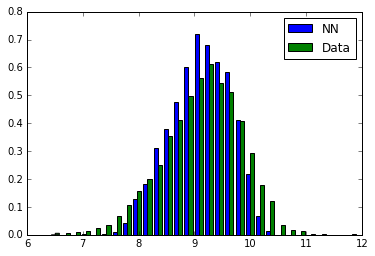

In [131]:
plt.hist([y_pred, y_test], bins=30, normed=True)
plt.legend(['NN', 'Data'])

In [132]:
# y_pred = nn.predict(X_gen)

In [133]:
# y_pred = lr.predict(X_gen)

In [134]:
y_pred = rf.predict(X_gen)

In [135]:
_, bins = np.histogram(np.concatenate([y_pred, y_test]), bins='auto')
h1, _ = np.histogram(y_pred, bins=bins)
h2, _ = np.histogram(y_test, bins=bins)

from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np

def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

print(JSD(h1, h2))

0.0610356256168


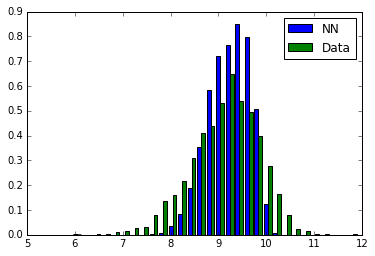

In [136]:
plt.hist([y_pred, y_test], bins=30, normed=True)
plt.legend(['NN', 'Data'])

In [137]:
X_gen[y_pred < 7, 11]

array([ 7.5,  0. , -1. , -0.5,  0. ,  0. ,  0. ,  3.5,  3. ,  0. ])

In [139]:
from collections import defaultdict
puma_to_kwh = defaultdict(list)

step = 100000

for i in range(0, len(pums), step):
    block = pums[i:i+step].dropna()
    print(i, len(block))
    X = block[join_columns].fillna(-1).as_matrix()
    X = scaler.transform(X)
    y = rf.predict(X)
    for puma_id, weight, val in zip(block.PUMA, block.WGTP, y):
        puma_to_kwh[puma_id].append((weight, val))

(0, 91870)
(100000, 92397)
(200000, 92465)
(300000, 92423)
(400000, 92475)
(500000, 92199)
(600000, 92588)
(700000, 93173)
(800000, 92100)
(900000, 91485)
(1000000, 92366)
(1100000, 91484)
(1200000, 91831)
(1300000, 92463)
(1400000, 92374)
(1500000, 91262)
(1600000, 91942)
(1700000, 92413)
(1800000, 93353)
(1900000, 91642)
(2000000, 91691)
(2100000, 92069)
(2200000, 91364)
(2300000, 91251)
(2400000, 91706)
(2500000, 92242)
(2600000, 92365)
(2700000, 92163)
(2800000, 91765)
(2900000, 92355)
(3000000, 91632)
(3100000, 59439)


In [140]:
import json
with open('../../models/vectorized_puma_regions/puma_list.json') as f:
    puma_mapping = json.load(f)
    puma_mapping = dict((int(value), int(key)) for key, value in puma_mapping.items())

In [141]:
def weighted_mean_std(x, weights):
    prob = weights / np.sum(weights)
    mean = np.sum(x * prob)
    dx = x - mean
    var = np.sum(prob * np.power(dx, 2))
    std = np.sqrt(var)
    return mean, std

In [142]:
results = []
for key, values in puma_to_kwh.items():
    weights = [w for w, v in values]
    values = [v for w, v in values]
    mean, std = weighted_mean_std(values, weights)
    results.append((puma_mapping[key], mean, std))
results = pd.DataFrame(results, columns=["PUMA", "elec_mean", "elec_std"])

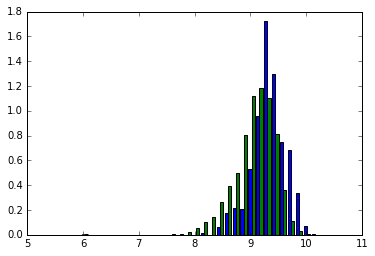

In [143]:
# Inspect a random histogram
for key, values in puma_to_kwh.items():
    weights = [w for w, v in values]
    values = [v for w, v in values]
    if np.random.rand() < 0.01:
        plt.hist([values, y], normed=True, bins=30)
        break

In [144]:
results.to_csv("community_distributions.csv", index=False)

In [146]:
np.percentile(results.elec_mean, 95)

9.5000990646581229

In [ ]:
# diffs = []
# for column in join_columns:
#     p_col = pums_sample[[column]].fillna(-1).as_matrix().flatten()
#     h_col = household[[column]].fillna(-1).as_matrix().flatten()
#     both = np.concatenate((p_col, h_col))
#     _, bins = np.histogram(both, bins='auto')
#     if len(bins) >= np.max(both) - np.min(both) - 1:
#         _, bins = np.histogram(both, bins=int(np.max(both) - np.min(both)))
#     if len(bins) <= 3:
#         _, bins = np.histogram(both, bins=2)
#     if len(bins) >= 100:
#         _, bins = np.histogram(both, bins=100)
        
#     hist_p, _ = np.histogram(p_col, bins=bins)
#     hist_p = hist_p.astype(np.float) / norm(hist_p, ord=1)
#     hist_h, _ = np.histogram(h_col, bins=bins)
#     hist_h = hist_h.astype(np.float) / norm(hist_h, ord=1)
#     diff = JSD(hist_p, hist_h)
#     diffs.append((diff, column, hist_h.tolist(), hist_p.tolist(), bins))
    
# diffs = sorted(diffs, reverse=True)

# for d, c, h, p, b in diffs:
#     plt.plot(b, h + [0], b, p + [0])
#     plt.title("%s - %0.3f" % (c, d))
#     plt.legend(['H', 'P'], loc='best')
#     plt.show()

In [147]:
np.mean(y)

9.05893996828698

In [148]:
np.exp(9.1)

8955.2927034825079